# California housing data set

I'm going to train an SVM regressor on the California housing data set. The data set can be found at [Aurélien Geron's GitHub web site](https://github.com/ageron/handson-ml/tree/master/datasets/housing). The README at the web site gives a good explanation of the data set.

Let's start by doing some exploratory data analysis.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [3]:
WORK_DIR = '/Users/angelo/Programming/Python/ageron-hands-on-machine-learning/datasets/housing'
file_name = os.path.join(WORK_DIR, 'housing.csv')

In [4]:
housing_df = pd.read_csv(file_name)
category = list(housing_df.select_dtypes('object').columns)
housing_df[category] = housing_df[category].astype('category')
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null category
dtypes: category(1), float64(9)
memory usage: 1.4 MB


We can see that there are 207 null values for the `total_bedrooms` feature. We will need to address this, by using the median to fill in the null values for example.

In [6]:
housing_df.isnull().sum()

longitude             0  
latitude              0  
housing_median_age    0  
total_rooms           0  
total_bedrooms        207
population            0  
households            0  
median_income         0  
median_house_value    0  
ocean_proximity       0  
dtype: int64

In [7]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [8]:
housing_df.nunique()

longitude             844  
latitude              862  
housing_median_age    52   
total_rooms           5926 
total_bedrooms        1923 
population            3888 
households            1815 
median_income         12928
median_house_value    3842 
ocean_proximity       5    
dtype: int64

In [9]:
housing_df.ocean_proximity.unique()

[NEAR BAY, <1H OCEAN, INLAND, NEAR OCEAN, ISLAND]
Categories (5, object): [NEAR BAY, <1H OCEAN, INLAND, NEAR OCEAN, ISLAND]

Let's generate a pairwise grid plot for some of the numerical features in the data set. We'll plot the geographic coordinates in the next plot.

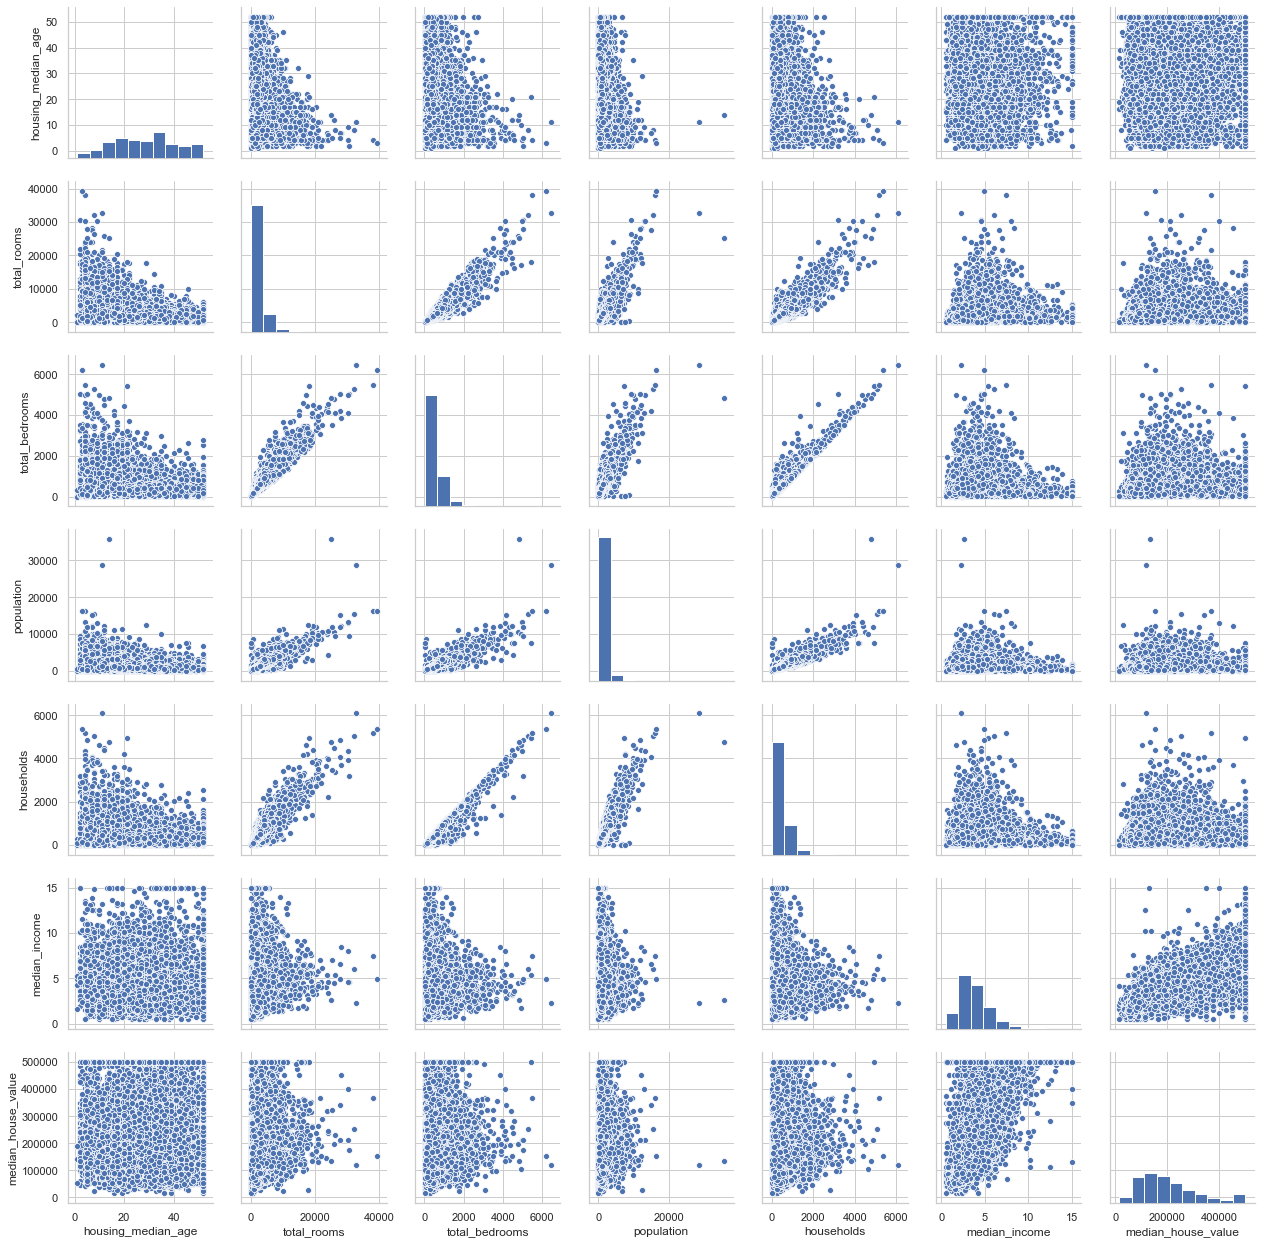

In [29]:
sns.set(style="whitegrid")
cols = housing_df.columns[2:-1]
sns.pairplot(data=housing_df[cols], kind='scatter', diag_kind='hist');

Here we can see the geographical districts color-coded for median house price. The San Francisco bay area and the greater Los Angeles / San Diego area are notoriously expensive.

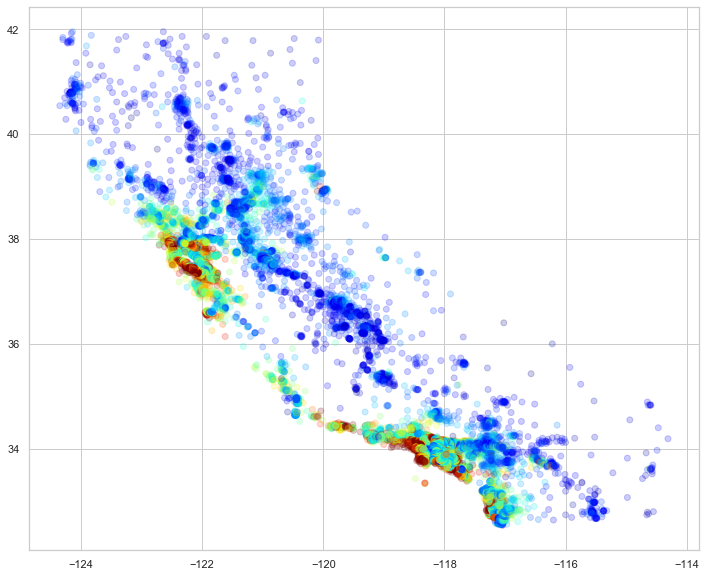

In [45]:
fig, axes = plt.subplots(1, 1, figsize=(12, 10))
lat, long, med_price = housing_df.iloc[:, 0], housing_df.iloc[:, 1], housing_df.iloc[:, -2]
axes.scatter(x, y, c=med_price, cmap=plt.cm.jet, alpha=0.2);